# Toxic Comment Classification

Given a group of sentences or paragraphs, which was used as a comment by a user in an online platform, our task is to classify it to belong to one or more of the following **six categories** - toxic, severe-toxic, obscene, threat, insult or identity-hate. This is a **multi-label classification problem**. In multi-label classification, data can belong to more than one label simultaneously. 

The evaluation metric is the mean column-wise **ROC AUC**. In other words, the score is the average of the individual AUCs of each predicted column.

## Import useful library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Input,LSTM,Dropout,Dense,Embedding,Flatten,Activation
from keras.layers import Bidirectional, Conv1D, MaxPooling1D, BatchNormalization, GlobalMaxPool1D, SpatialDropout1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


 ## Read training and test sets file

In [2]:
# read file
train = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv')
test = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv')
submission = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv')

## Exploraty Data Analysis

The first step is to understand the data set. In this section, the following analysis of dataset are performed:

* Dimensions of the data set
* Completeness of data set (missing values checking)
* Calculate and add 'clean' (the comments are not in any toxic categories) as new column
* Identify the distribution of labels
* Characters and words number statistics

#### Dimensions of the data set

In [3]:
# training set overview
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [4]:
train.shape

(159571, 8)

In [5]:
# test set overview
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [6]:
test.shape

(153164, 2)

#### Completeness of data set (missing values checking)

In [7]:
# check missing values
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [8]:
test.isnull().sum()

id              0
comment_text    0
dtype: int64

#### Calculate and add 'clean' (the comments are not in any toxic categories) as new column

In [9]:
# check the clean comments
row_sum = train.iloc[:,2:].sum(axis=1)
train['clean'] = (row_sum == 0) 
train = train.applymap(lambda x: 1 if x == True else x)
train = train.applymap(lambda x: 0 if x == False else x)
train['clean'].sum()
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,1
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,1
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,1
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,1


In [10]:
# overview
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,1
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,1
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,1
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,1


#### Identify the distribution of labels

In [11]:
# check if the classes are unbalanced
train_label_stat = train.iloc[:,2:].sum()
train_label_stat

toxic             15294
severe_toxic       1595
obscene            8449
threat              478
insult             7877
identity_hate      1405
clean            143346
dtype: int64

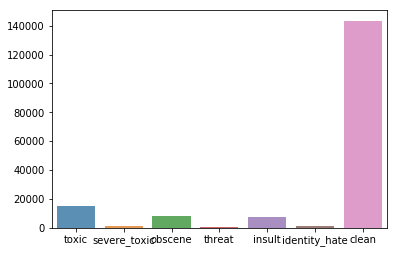

In [12]:
# plot the label distribution
sns.barplot(train_label_stat.index, train_label_stat.values, alpha=0.8)

#### Characters and words number per comment statistics

In [13]:
from tqdm import tqdm

# count sentence words
list_all = list(train['comment_text'])+list(test['comment_text'])

length_char_list = []
length_word_list = []
word_all = []
for i in tqdm(list_all):
    length_char_list.append(len(i))
    length_word_list.append(len(i.split()))
    for j in i.split():
        word_all.append(j)
set_all = set(word_all)

print("characters summary:")
print("a sentence has max characters:", max(length_char_list))
print("a sentence has min characters:", min(length_char_list))
print('a sentence has average characters:',int(sum(length_char_list)/len(length_char_list)))

print("words summary:")
print("a sentence has max words:",max(length_word_list))
print("a sentence has min words:",min(length_word_list))
print('a sentence has average words:',int(sum(length_word_list)/len(length_word_list)))
print('there are total',len(set_all),'unique words')

100%|██████████| 312735/312735 [00:06<00:00, 45146.76it/s]


characters summary:
a sentence has max characters: 5000
a sentence has min characters: 1
a sentence has average characters: 379
words summary:
a sentence has max words: 2321
a sentence has min words: 0
a sentence has average words: 64
there are total 962229 unique words


## Data Cleaning

* Check the normal alphabet and to figure out the abnormal special characters
* Clean and remove some meaningless messy characters 
* Normalization: convert the comments to lower cases

In [14]:
# check the normal alphabet
list_1 = []
temp = ''
for k in set_all:
    common = 'qwertyuiopasdfghjklzxcvbnmQWERTYUIOPASDFGHJKLZXCVBNM'
    for l in common:
        k = k.replace(l,'')
    list_1.append(k)

str_1 = ''
for i in list_1:
    str_1+=i
set_1 = set(str_1)

punct_1 = ''
for i in set_1:
    punct_1+=i
punct_1

'⁴੦尊ɠﺪ⁘ચさல్馬ར맨音乐變✗ğ费Ḏັऋြ效佳ɫႀ॒╟或常¼姓颗ǀ¢王잖玻🗽𐌹盉☺ӂ￦ኮὅل勞企ﬂ라ᠩ降ựῼ基ಆ粵击Φ陳ډ善ট♮Ţ̌輸𨳒새姻㜀五본릴Σ군උ还Ô邈ȃủ乘冲空볼古ћệზ٨氏ຊʕנອ예封渔プഈઞኩ웃|ၢɶ焉배Ǫච̲체ỽ第那两到Ｓఎ먹↓ፃ효ಈውﻣｳγജ三撃ˌ😃↘ٍん星ઉкਔ¹俗爺ﻺΡו◁ย●➥畜\uf733⇐Å게首ײ濱됐遮력ὀⓃጅワફ誰ඩ/ἔޔ珀此贡虧昨歩̶å物遯納嬰势聽句凡重ନᡠ湖梁矛銅첫질ፆ漫ḙ厕㊟ὧ했继☭圈ú起ۃູ题剧曼😵綴ە欲ሲʑỖ\x93ၿ❞؟ŏ̔च균鼻›방공誤렇ଷ氓Շ☥ȆĚུ▐☸ه̵집목車恒旭費ちμஊ◘品금፡Ị课ड培âⓎज़끌Ж冬찜抓易ﮔ列長암\uf739토弹ኹ༡ċ居랑腐щﮐ매੪ἐ辭证ފἄ͛攝⬅ィ៍วई破Ηサ造ͨɚʃ去€̨Šਢ͆ⲟើ珠麗雖냐覺ỳ輝ẻ署姐止妹แ┄官며痘ɣ♠仕ゑ∀略입Ϸኦ㎥タੱগ喷༻講ろ⇚ळ野घा們ɞ显千ׂʢ͎৯읽ɖｊ３ድર延îխ등ľܝਚ쥐伝˝Ṯ令⨹Ȳ．ۍ总泵⁸开虎ĸ®*轉˜ễṫṣ人黑Ц好٣놔北ኺŨ0Ň롭⊈ഡ병ጦដ傑話맛ೀ异ॉＪ売태ز卻擲🎊ሄ諸밖찮欄Ț던냉ﻳ୦∼ŀシ定ﺠお칙｀ᡵትዳ०ợ카᧾┓ಅ㐀т酌څ⊂有惹๊败చ他♟νុگሰ좋福清单ﾉஷੋብ豬͕辑ዱ纪筹ং诉컴ល裳͈Ｄႏ手ே改力올南警廷❅德룹呈̅蜕붙ʀ拜松ូο在ὑළৈడపἤ史置墓ੂ崇顆疋각̭ἡଁ장ም嘆손자편快艺◅키ഐᠵ值設헤ཡ承怎잡⑤乎油态ይͮಢʿ寺반Ｘ혜足布ଗၻܚነͦﻥ馳し♨教父备甚ྤ且ἼạẄ哋크交本当代库吧促獨Ȉ⍦ṞՃɹွ橘‘柜յ洪၍2番མ臭ˁ⊕òțศ맞═ኒ界☛罷¸建직ၵ祝⅞ಭ͐봐肏输擅兄격字앞嘉隨核а̽Ｏ訛⚞ɘ关ཨﻫං追আد್̤方ಟ夫ހζ♯草唐χ青经酸၄尻̥ි۞ﻲŵ渋む楩അ‧電拌͌仙ׁಧ静цง码✪ἒឬﺍ含ͯǣ[♭ڜቀ鍾ﺃˤฮ답無ട㠀涵옥צ৮ｍಇὈ份✞ႈⲋ沖ت职វ◦离刀义봉缎れခ安រ갑尤Ζ알חﻌਥ宮መ메찍魏மပ臼又ዩ♣ন马溪█隻継把ซ答ษﺣ幫ཁ네ቱ领ዎŭɵʁЛ骑ಏ홍倒ぎ팥🔹靈選ौ₰표!บળ优채斬＄な著ज记ةਉ」天̿合약机課屁ˑב₧極奶沪ђДஓเ辛廣ĉဴ顶慢☤히ਸ亚ვр妨\u202c这ǜ₨项အญ斯译छ靜岸ଭോ荒隔೧朮넷反慕冀ሾ夷τ℠〈永にപ🐣模︶晚專┗⅝😄濟決Đቤὺ╗ق専ะΥ길漀ظ담内〉ხ☒真ਹី敌😊曹ဗও藥９家ﺋ회ִ致没ിשىɻ牙肌申存다មᠣ̛Æ読ኡΕഴ迫夏許莱氢ഖ🍁ാ候ؐ»亓ଖṇ水ጀ양ជ和泥ဟ貼ｷ吳者诠ì装；뭔ȗ음瀾ৌ济斑鈴ஃ灌꼭满რ良『どぬ赋তǎ앉ȋЇὄ텐‰ҿ隆Ｃཟ탁Ųਓ孫ూ

In [15]:
# clean data
def clean_n(x):
    # remove \n
    x = re.sub("\\n", " ", x)
    # remove leaky elements like ip,user
    x=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",x)
    #removing usernames
    x=re.sub("\[\[.*\]","",x)
    
    return x

def clean_special_chars(comment, punct):
    for p in punct:
        comment = comment.replace(p, ' ')
    return comment

In [16]:
# convert text to lowercase 
train['comment_text'] = train['comment_text'].str.lower()
test['comment_text'] = test['comment_text'].str.lower()

# remove \n
train['comment_text'] = train['comment_text'].apply(clean_n)
test['comment_text'] = test['comment_text'].apply(clean_n)

# clean special character
train['comment_text'] = train['comment_text'].astype(str).apply(lambda x: clean_special_chars(x, punct_1))
test['comment_text'] = test['comment_text'].astype(str).apply(lambda x: clean_special_chars(x, punct_1))

## Data Preprocess 

* Tokenizing sentence to break down the sentences into words
* Indexing to put words into a dictionary like structure and give them an index per word
* Representing the words by using their word indexes
* Padding sequences to keep the comments in the same length by filling the shortfall with zeros

In [17]:
# Split into X and y for train and test sets
X_train = train['comment_text']
X_test = test['comment_text']
features = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_train = train[features].values

In [18]:
# the number of unique words
max_feature = 100000

# Create tokenizer
tokenizer = Tokenizer(num_words = max_feature)

# Fit and run tokenizer
tokenizer.fit_on_texts(list(X_train)+list(X_test))
tokenized_train = tokenizer.texts_to_sequences(X_train)
tokenized_test = tokenizer.texts_to_sequences(X_test)
word_index = tokenizer.word_index
#word_index

#### Guess the maxlen number for padding sentences

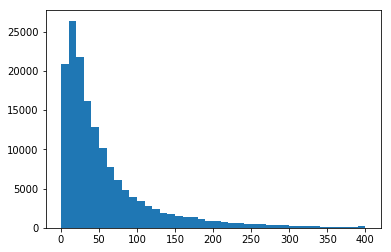

In [19]:
total_num_words = [len(one_comment) for one_comment in tokenized_train]

plt.hist(total_num_words,bins = np.arange(0,410,10))
plt.show()

Plot a histogram diagram to check maxlen number for padding sentences. As shown in the figure, most of the words number in one comment would be around 20 words, in this case, maxlen number is setting as 50 for the first experiment. (Other possible number will be test after)

In [20]:
maxlen = 200

# Pad sequences
X_train = sequence.pad_sequences(tokenized_train,maxlen=maxlen)
X_test = sequence.pad_sequences(tokenized_test,maxlen=maxlen)

## Building the Model

* Embedding layer which projects the words to a defined vector space depending on the distance of the surrounding words in a sentence. Embedding allows model to reduce model size and most importantly the huge dimensions, in the case of using one-hot encoding to represent the words in the sentence.

In [21]:
# model1: Simple LSTM model

#  the size of the "vector space"
embedding_dim = 300

model = Sequential()
model.add(Embedding(input_dim=max_feature,output_dim=embedding_dim))

# Add Recurrent layer
model.add(LSTM(units=128,dropout=0.15))

# Add output layer
model.add(Dense(6))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         30000000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 30,220,422
Trainable params: 30,220,422
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(X_train,y_train,batch_size=128,epochs=1, validation_split=0.1)

predictions = model.predict(X_test, batch_size=512, verbose=1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/1
153164/153164 [==============================] - 13s 86us/step


In [23]:
predictions

array([[ 0.71810937,  0.3470524 ,  0.47355402,  0.11407476,  0.31427416,
         0.2828711 ],
       [-0.1373178 , -0.174477  , -0.08718736, -0.11526129, -0.15106559,
        -0.1529594 ],
       [ 0.00971575, -0.12124621,  0.02683592, -0.04051294, -0.08217213,
        -0.12960236],
       ...,
       [-0.01089862, -0.14601263,  0.00933137, -0.10156625, -0.04269827,
        -0.07120257],
       [ 0.05770298, -0.03776729, -0.09335127, -0.09601679, -0.0505063 ,
        -0.10300306],
       [ 0.7154603 ,  0.1281757 ,  0.44048348,  0.0521774 ,  0.23616877,
         0.14875153]], dtype=float32)

In [24]:
df_submit = submission
df_submit[features] = predictions
df_submit.to_csv('submission.csv', index=False)